<a href="https://colab.research.google.com/github/tuananhpa/Face_Reg/blob/main/Audio_Signal_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
freecolabgpu_audio_source_separation_path = kagglehub.dataset_download('freecolabgpu/audio-source-separation')

print('Data source import complete.')


Data source import complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display as ldp
import IPython.display as ipd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

csv_path = "/kaggle/input/audio-source-separation/mixed_dataset/metadata.csv"

df = pd.read_csv(csv_path)



df.loc[:,["mix_path"]] = "/kaggle/input/audio-source-separation/" + df.loc[:,["mix_path"]]
df.loc[:,["source_path"]] = "/kaggle/input/audio-source-separation/" + df.loc[:,["source_path"]]

df.head()
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

mix_id                                           mix_path  \
0  mix_0000  /kaggle/input/audio-source-separation/mixed_da...   
1  mix_0001  /kaggle/input/audio-source-separation/mixed_da...   
2  mix_0001  /kaggle/input/audio-source-separation/mixed_da...   
3  mix_0002  /kaggle/input/audio-source-separation/mixed_da...   
4  mix_0002  /kaggle/input/audio-source-separation/mixed_da...   

                                         source_path    class  
0  /kaggle/input/audio-source-separation/mixed_da...   speech  
1  /kaggle/input/audio-source-separation/mixed_da...   speech  
2  /kaggle/input/audio-source-separation/mixed_da...  traffic  
3  /kaggle/input/audio-source-separation/mixed_da...     wind  
4  /kaggle/input/audio-source-separation/mixed_da...  traffic

In [ ]:
less_df = df.iloc[:200]

In [ ]:
less_df['class'].value_counts()

class
traffic    58
speech     52
wind       52
music      38
Name: count, dtype: int64

### Split Path

In [ ]:
mix_path = less_df['mix_path']
mix_class = less_df['class']
source_path = less_df['source_path']
source_class = less_df['class']

In [ ]:
def LoadAudio(file_path):
    try:
        signal, sr = librosa.load(file_path)
        return pd.Series([signal,sr], index = ["signal","sr"])
    except Exception as e:
        print(f"error loadding file :  {e}")

In [ ]:

mix_combine_data = mix_path.apply(LoadAudio)
source_combine_data = source_path.apply(LoadAudio)

mix_df = pd.DataFrame(mix_combine_data, index=mix_combine_data.index, columns=mix_combine_data.columns)
source_df = pd.DataFrame(source_combine_data, index=source_combine_data.index, columns=source_combine_data.columns)

mix_df["class"] = mix_class
source_df["class"] = source_class

In [ ]:
mix_df

signal     sr    class
0    [0.0006713867, 0.0009460449, 0.0010375977, 0.0...  22050   speech
1    [-0.01473999, -0.022064209, -0.014465332, -0.0...  22050   speech
2    [-0.01473999, -0.022064209, -0.014465332, -0.0...  22050  traffic
3    [0.04534912, 0.069122314, 0.051879883, 0.04852...  22050     wind
4    [0.04534912, 0.069122314, 0.051879883, 0.04852...  22050  traffic
..                                                 ...    ...      ...
195  [0.0007019043, 0.0008544922, 0.0002746582, -9....  22050   speech
196  [0.0007019043, 0.0008544922, 0.0002746582, -9....  22050  traffic
197  [0.0007019043, 0.0008544922, 0.0002746582, -9....  22050    music
198  [-0.2135315, -0.33602905, -0.29232788, -0.2887...  22050    music
199  [-0.2135315, -0.33602905, -0.29232788, -0.2887...  22050     wind

[200 rows x 3 columns]

In [ ]:
mix_vector_data = mix_df["signal"]
source_vector_data = source_df["signal"]

In [ ]:
mix_vector_data[0].shape, source_vector_data[0].shape

((220500,), (220500,))

In [ ]:
def PlotAudio(data):
  fig, axes = plt.subplots(2,5, figsize = (20,10))

  for i in range (2):
      for j in range (5):
          axes[i][j].plot(data[i*5+j])
          axes[i][j].set_title(f"Volume {i*5+j}")

  plt.tight_layout()
  plt.show()


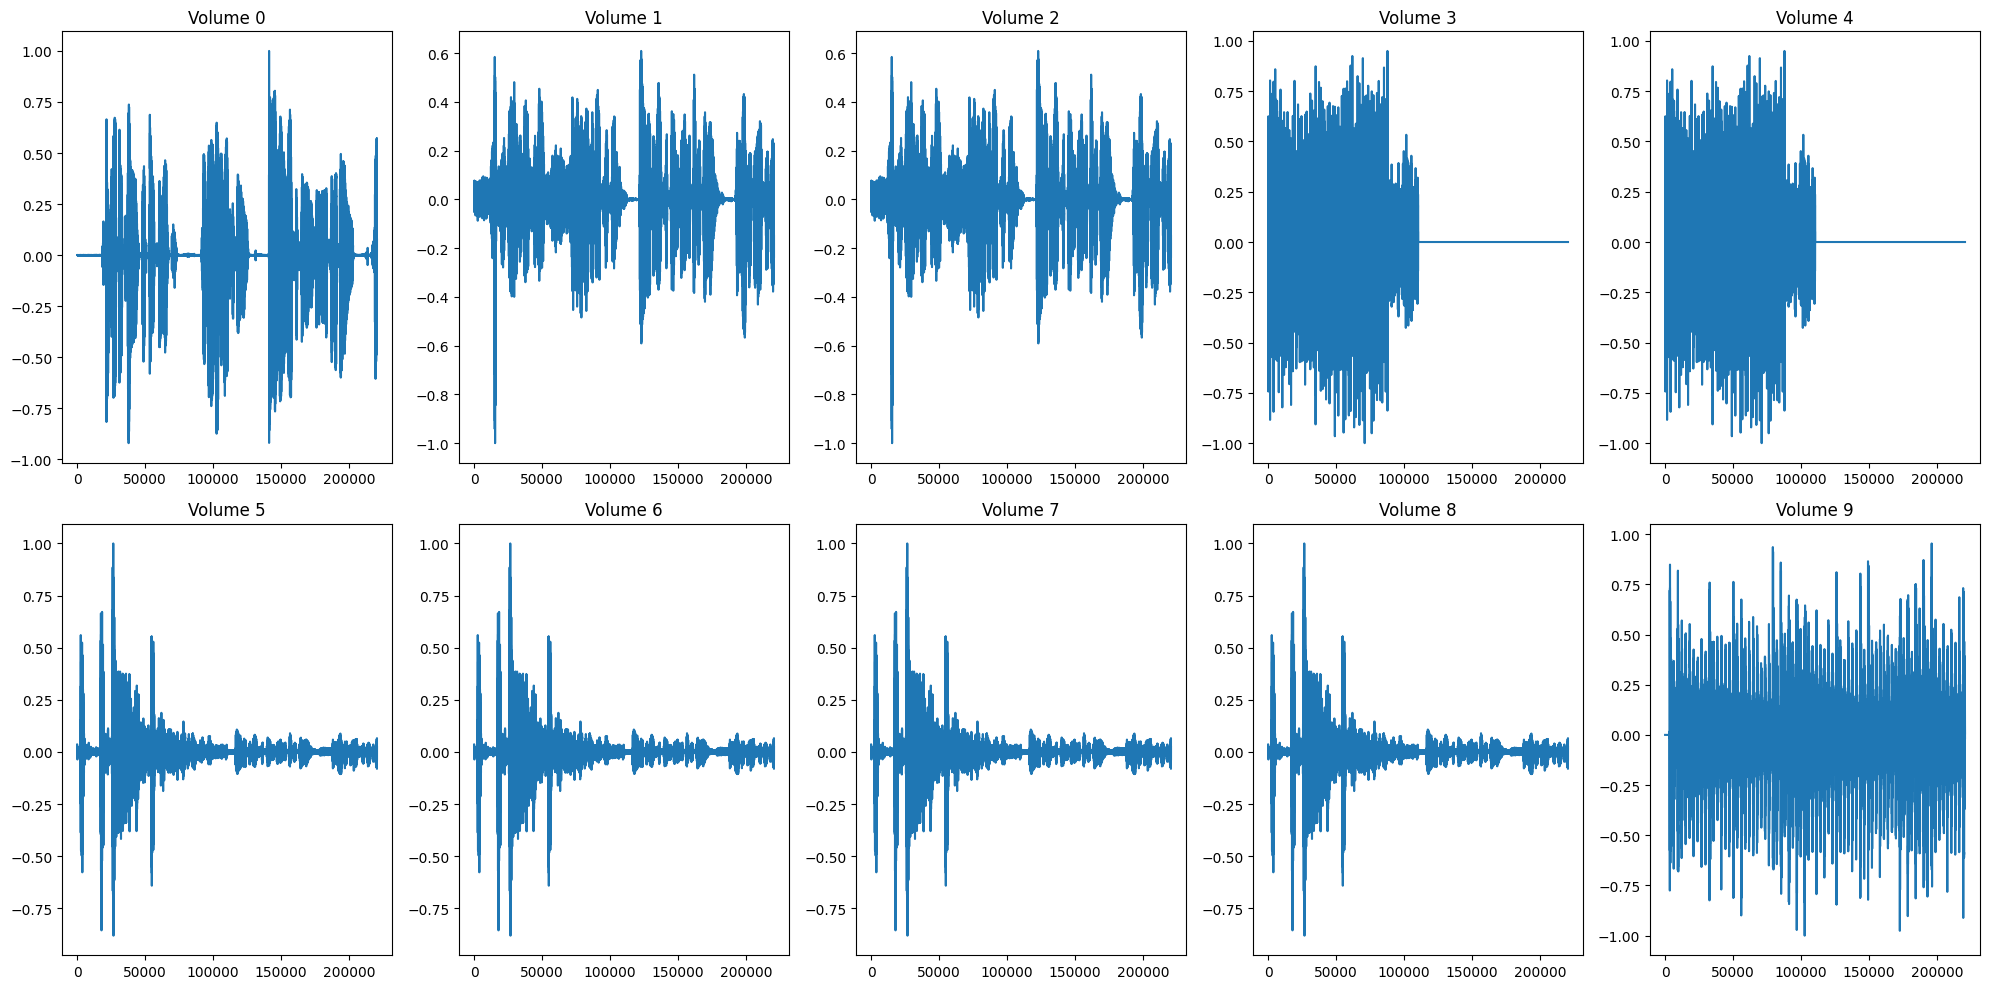

In [ ]:
PlotAudio(mix_vector_data)

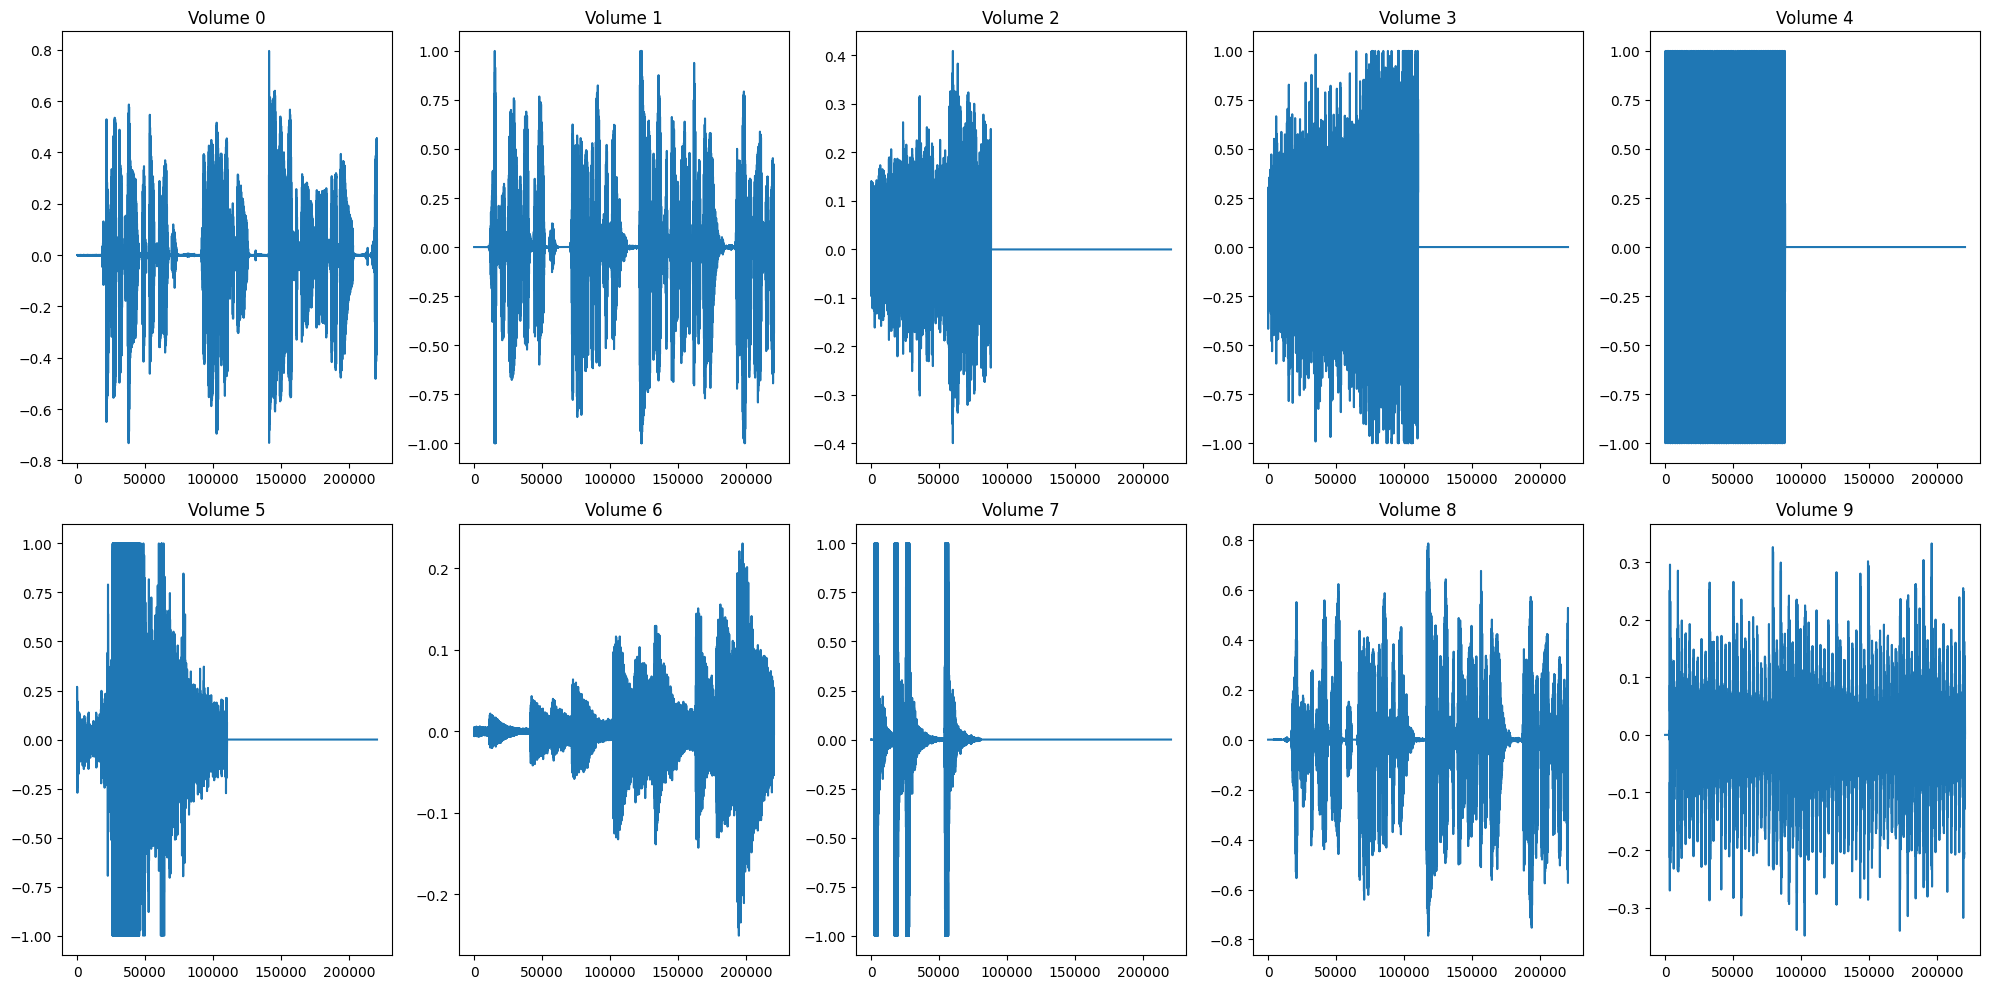

In [ ]:
PlotAudio(source_vector_data)

Volume 3 và volume 4 xuất hiện đoạn tĩnh ở đầu dẫn đến việc dư thừa cho tính toán

In [ ]:
def TrimEffect(data):
  try:
    return librosa.effects.trim(data, top_db=20)[0]
  except Exception as e:
    print(f"error trimming file :  {e}")

mix_trim_data = mix_vector_data.apply(TrimEffect)
source_trim_data = source_vector_data.apply(TrimEffect)

In [ ]:
PlotAudio(mix_trim_data)

In [ ]:
PlotAudio(source_trim_data)

In [ ]:
ipd.Audio(mix_path[4])

In [ ]:
ipd.Audio(source_path[4])

# Spectrogram

In [ ]:
def SpectroLoad(data):
  try:
    return librosa.stft(data)
  except Exception as e:
    print(f"error loading file :  {e}")

mix_spectro_data = mix_trim_data.apply(SpectroLoad)
source_spectro_data = source_trim_data.apply(SpectroLoad)

In [ ]:
mix_spectro_data[0].shape, source_spectro_data[0].shape

((1025, 392), (1025, 392))

In [ ]:
def PlotSpectro(vector, nums = 0):
  if(nums == 0):
    librosa.display.specshow(vector, sr=22050, x_axis='time', y_axis='log')
    plt.title(f"Spectrogram volume")
    plt.colorbar()
    plt.show()
    return
  for i, idx in enumerate(vector.index[:nums]):
    librosa.display.specshow(vector[idx], sr=22050, x_axis='time', y_axis='log')
    plt.title(f"Spectrogram volume {i}")
    plt.colorbar()
    plt.show()

/tmp/ipython-input-972911832.py:9: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(vector[idx], sr=22050, x_axis='time', y_axis='log')


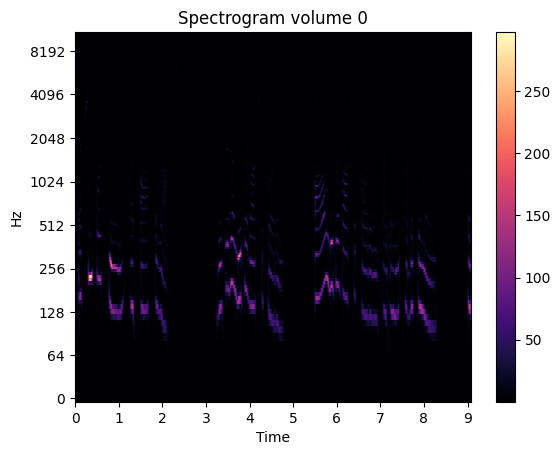

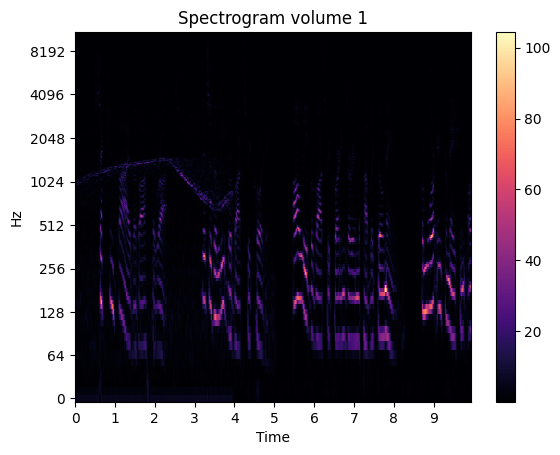

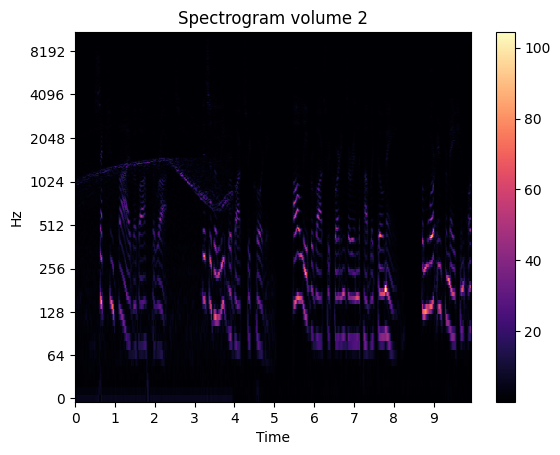

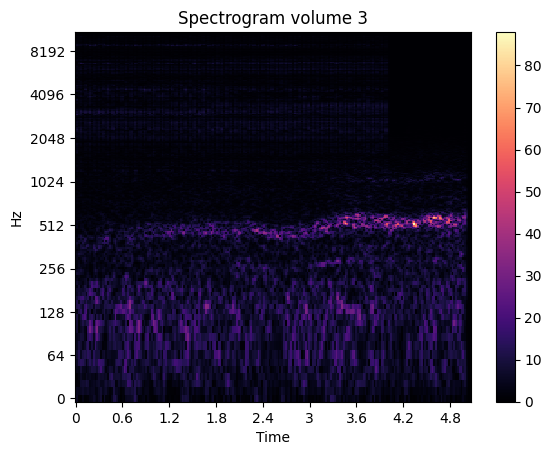

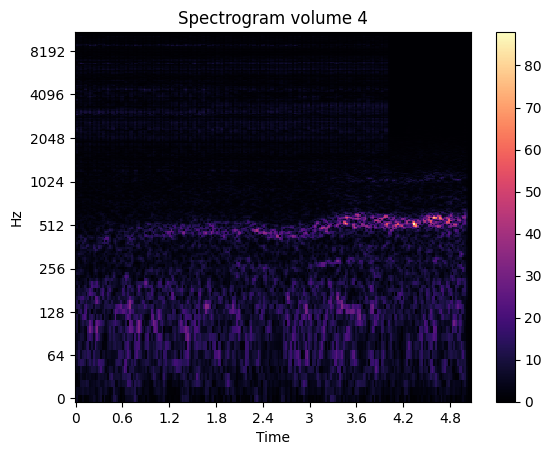

In [ ]:
PlotSpectro(mix_spectro_data, 5)

In [ ]:
def magnitudeSpectro(data):
    try:
        return librosa.amplitude_to_db(np.abs(data), ref = np.max)
    except Exception as e:
        print(f"error loading file :  {e}")


In [ ]:
mix_db_spectro_data = mix_spectro_data.apply(magnitudeSpectro)
source_db_spectro_data = source_spectro_data.apply(magnitudeSpectro)

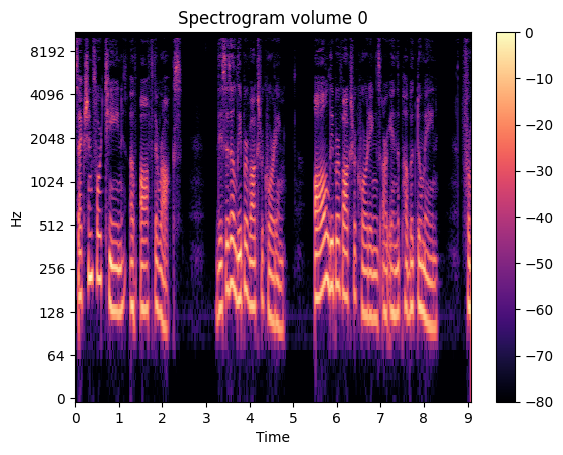

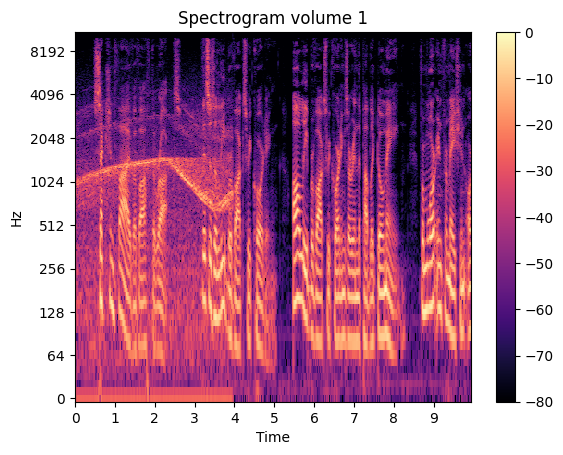

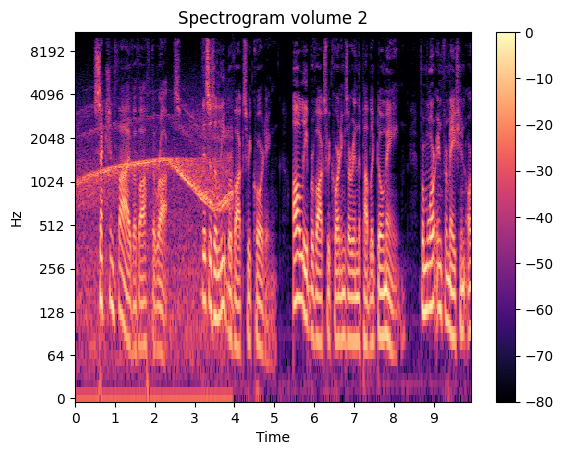

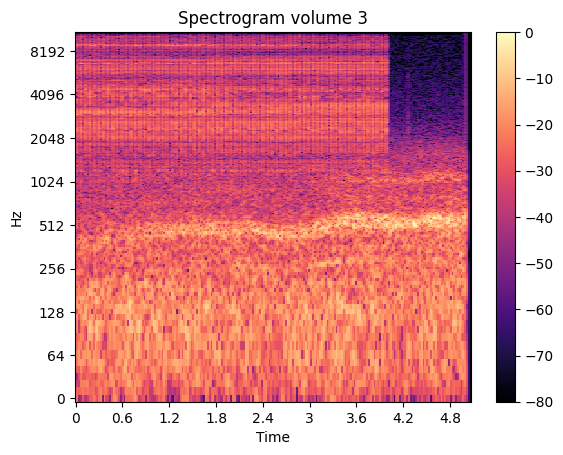

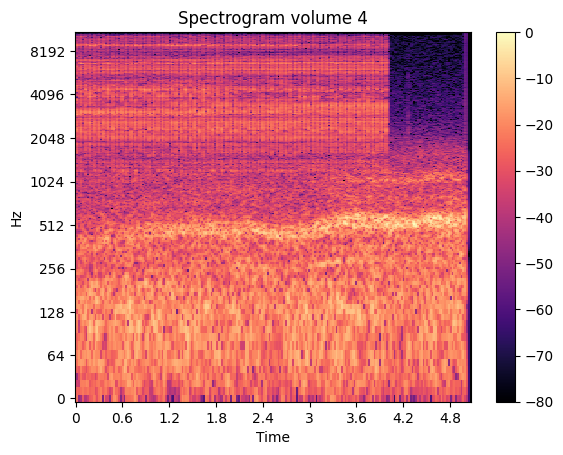

In [ ]:
PlotSpectro(mix_db_spectro_data, 5)

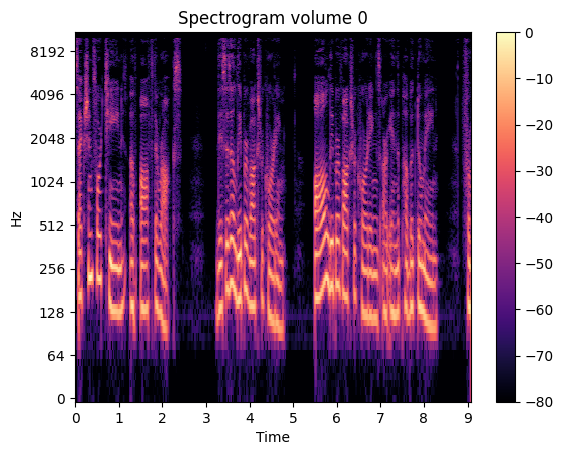

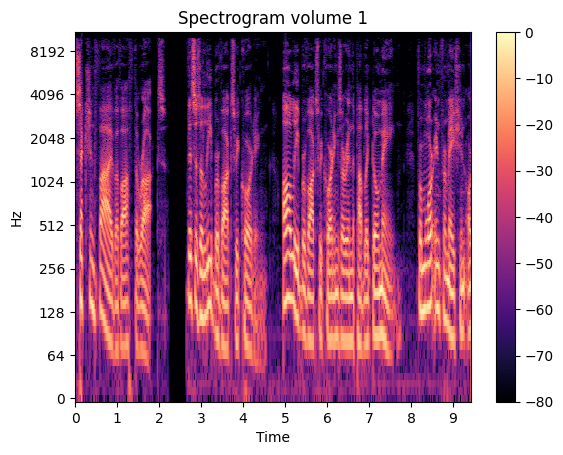

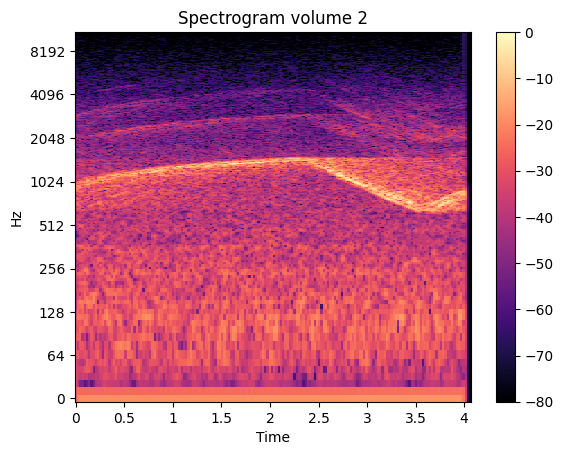

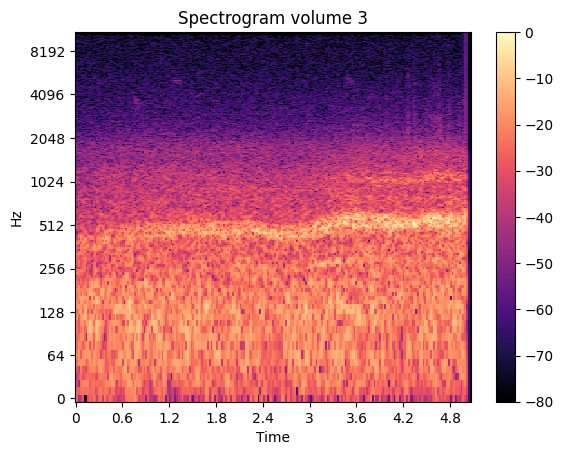

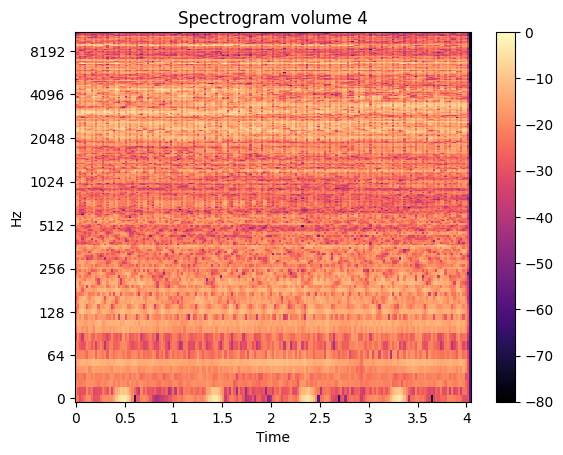

In [ ]:
PlotSpectro(source_db_spectro_data, 5)

Using Scipy.io wavfile Để có thể trích xuất các channel

In [ ]:
from scipy.io import wavfile

def LoadAudioWavFile(data):
  try:
    sr, signal = wavfile.read(data)
    return pd.Series([sr,signal], index = ["sr","signal"])
  except Exception as e:
    print(f"error loading file :  {e}")

mix_wav_data = mix_path.apply(LoadAudioWavFile)
source_wav_data = source_path.apply(LoadAudioWavFile)

In [ ]:
mix_wav_data['signal'][0].shape, mix_wav_data['signal'][150].shape

((220500,), (220500,))

Được thu âm với chỉ 1 channel (nguồn âm như micro -> ko chứa các thông tin về chiều thứ 3)

In [ ]:
source_wav_data['signal'][0].shape, source_wav_data['signal'][134].shape

((220500,), (220500,))

# ***Nonnegative Matrix Factorization***



## 1.   Prepare Source Data for training model



In [ ]:
source_df = df[["source_path","class"]]
source_df["class"].value_counts()

class
wind       650
traffic    629
music      625
speech     623
Name: count, dtype: int64

Split data base on class

In [ ]:
wind_df = source_df[source_df["class"] == "wind"].drop("class",axis = 1)
traffic_df = source_df[source_df["class"] == "traffic"].drop("class",axis = 1)
music_df = source_df[source_df["class"] == "music"].drop("class",axis = 1)
speech_df = source_df[source_df["class"] == "speech"].drop("class",axis = 1)

In [ ]:
wind_df.shape

(650, 1)

Feature extractor

In [ ]:
def FeatureExtractor(data_path):
  try:
    data = data_path.apply(LoadAudio)
    data_signal = data["signal"]
    data_trim = data_signal.apply(TrimEffect)
    data_spectro = data_trim.apply(SpectroLoad)
    data_spectro_magnitude = data_spectro.apply(magnitudeSpectro)
    data_concat = np.concatenate(data_spectro_magnitude.tolist(), axis = 1)
    return data_spectro, data_spectro_magnitude, data_concat
  except Exception as e:
    print(f"error loading file :  {e}")

In [ ]:
wind_spectro, wind_spectro_magnitude, wind_concat = FeatureExtractor(wind_df['source_path'])
traffic_spectro, traffic_spectro_magnitude, traffic_concat = FeatureExtractor(traffic_df['source_path'])
music_spectro, music_spectro_magnitude, music_concat = FeatureExtractor(music_df['source_path'])
speech_spectro, speech_spectro_magnitude, speech_concat = FeatureExtractor(speech_df['source_path'])

In [ ]:
wind_spectro_magnitude.iloc[0].shape, wind_concat.shape

In [ ]:
PlotSpectro(wind_spectro_magnitude, 5)

Model NMF

1. Wind Model

In [ ]:
class NMF():
  def __init__(self, n_components=2, init='random', random_state=42, max_iter=200):
    self.W = None
    self.H = None
    self.n_components = n_components
    self.init = init
    self.random_state = random_state
    self.max_iter = max_iter

  def GetComponents(self, k):
    self.n_components = k;

  def GenerateModel(self, data_spectro, data_spectro_origin, FuctionCost = 'F'):
    w, h = data_spectro.shape #width = magnitude, h = time
    self.M = data_spectro
    self.M_origin = data_spectro_origin
    self.W = np.random.rand(w, self.n_components)
    self.H = np.random.rand(self.n_components, h)
    self.Minimize(FuctionCost)

  def Frobenius_Norm(self, M, W, H):
    return np.linalg.norm(M - np.dot(W,H),'fro')

  def Kullback_Leibler(self, M,W,H):
    return M*np.log(M/(np.dot(W,H))) - M + np.dot(W,H)

  def Multiplicative_Update(self, M, W, H):
    H = H * (np.dot(W.T, M) / np.dot(W.T, np.dot(W, H)))
    W = W * (np.dot(M, H.T) / np.dot(W, np.dot(H, H.T)))
    return W, H

  def Minimize(self, FuctionCost = 'F'):
    self.previous_loss = np.inf
    for i in range(self.max_iter):
      self.W, self.H = self.Multiplicative_Update(self.M, self.W, self.H)
      if (FuctionCost == 'F'):
        loss = self.Frobenius_Norm(self.M, self.W, self.H)
      else:
        loss = self.Kullback_Leibler(self.M, self.W, self.H)
      print(f"Iteration {i}: Loss: {loss}")
      if np.abs(loss - self.previous_loss) < 1e-10:
        break
      self.previous_loss = loss

  def Masking(self, W, H):
    sound_data = np.zeros(1)
    M_t = np.dot(W,H)
    for i in range (self.n_components):
      W_i = self.W[:,i]
      H_i = self.H[i,:]
      sound_spectro = np.dot(W_i,H_i)
      mask = sound_spectro / M_t
      multi = mask * self.M_origin
      sound_data.append(librosa.istft(multi))
    return sound_data




In [ ]:
wind_model = NMF(n_components=1,max_iter=100)
wind_model.GenerateModel(wind_concat)

In [ ]:
traffic_model = NMF(n_components=1,max_iter=100)
traffic_model.GenerateModel(traffic_concat)

In [ ]:
# music_model = NMF(n_components=1,max_iter=100)
# music_model.GenerateModel(music_concat)

In [ ]:
# speech_model = NMF(n_components=1,max_iter=100)
# speech_model.GenerateModel(speech_concat)